In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [316]:
from torch.utils.data import DataLoader, TensorDataset

In [532]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
plt.style.use('seaborn-v0_8-whitegrid')
# plt.style.use('ggplot')
# plt.style.use('seaborn-v0_8-notebook')

In [125]:
class Linear:
  
    def __init__(self, in_size, out_size, bias=True):
        self.weight = torch.randn((in_size, out_size), generator=g) / in_size**0.5
        self.bias = torch.zeros(out_size) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


In [126]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [127]:
class ReLu:
    def __call__(self, x):
        self.input = x
        self.out = torch.relu(x)
        return self.out
    def parameters(self):
        return []
    
#     def forward(self, x):
#         return self(x)
    
    def backward(self, da):
        return (self.input > 0) * da

In [351]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [352]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [353]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()
x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()
# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=25, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=25)

Text(0.5, 1.0, 'Generated Data - Train')

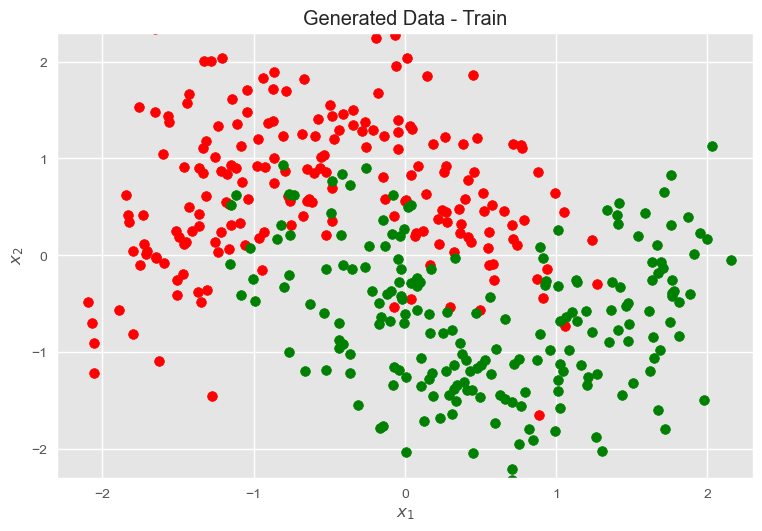

In [354]:
fig, ax = plt.subplots()
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])
colors = ("red", "green", "blue")

for c in np.unique(y_train):
    ax.scatter(X_train[y_train == c, 0], X_train[y_train == c, 1], c=colors[c])
# ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])

# ax.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], ls='none', marker ='o')
# ax.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], ls='none', marker ='s')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xlim([-2.3, 2.3])
ax.set_ylim([-2.3, 2.3])
ax.set_title('Generated Data - Train')

In [153]:
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train.reshape(-1, 1)).float()

X_train_tensor.shape, y_train_tensor.shape

(torch.Size([80, 2]), torch.Size([80, 1]))

In [154]:
input_dim, hidden_dim, output_dim = 2, 10, 1

In [238]:
W1 = torch.randn((input_dim, output_dim), generator=g, requires_grad=True)
b1 = torch.zeros((output_dim), requires_grad =True)

zs = X_train_tensor @ W1 + b1
loss = F.binary_cross_entropy_with_logits(zs, y_train_tensor, reduction='mean')
loss.backward()

W1.grad, b1.grad

(tensor([[-0.1753],
         [-0.0558]]),
 tensor([0.0176]))

In [312]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
l1 = Linear(input_dim, hidden_dim)
l2 = Linear(hidden_dim, output_dim)

layers = [l1, ReLu(),l2]
parameters = [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
    
# forward computation
# zs = X_train_tensor
# for layer in layers:
#     zs = layer(zs)
# loss = F.binary_cross_entropy_with_logits(zs, y_train_tensor, reduction='mean')
# loss.backward()

In [313]:
lri = []
lossi = []
stepi = []

In [314]:
for epoch in range(100):
  
  # minibatch construct
#     ix = torch.randint(0, X_train_tensor.shape[0], (80,))
    ix = torch.arange(X_train_tensor.shape[0])
  # forward pass
    zs = X_train_tensor[ix]
    for layer in layers:
        zs = layer(zs)
    loss = F.binary_cross_entropy_with_logits(zs, y_train_tensor[ix], reduction='mean')
  #print(loss.item())
  
  # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 5000 else 0.01
#     lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item())

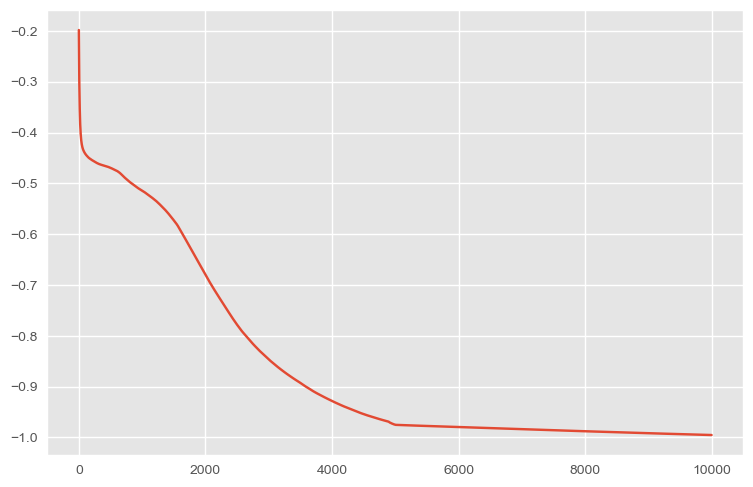

In [315]:
plt.plot(stepi, lossi)

In [365]:
class MLP:
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        yhat = x
        for layer in self.layers:
            yhat = layer(yhat)
        return yhat
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [441]:
# g = torch.Generator().manual_seed(2147483647) # for reproducibility
l1 = Linear(input_dim, hidden_dim)
l2 = Linear(hidden_dim, hidden_dim)
l3 = Linear(hidden_dim, output_dim)

nnet = MLP([l1, ReLu(), l2, ReLu(), l3])
parameters = nnet.parameters()

for p in parameters:
    p.requires_grad = True

    
# number of epochs
n_epochs = 1000

losses = []
lr = 0.01
# For each epoch...
for epoch in range(2000):
    # inner loop
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        # Performs one train step and returns the corresponding loss 
        # for this mini-batch
#         yhat = x_batch
#         for layer in layers:
#             yhat = layer(yhat)
        yhat = nnet(x_batch)
        loss_batch = F.binary_cross_entropy_with_logits(yhat, y_batch)    
        
        for p in parameters:
            p.grad = None
        loss_batch.backward() 
        
        for p in parameters:
            p.data += -lr * p.grad
        mini_batch_losses.append(loss_batch.squeeze().detach().numpy())

    # Computes average loss over all mini-batches - that's the epoch loss   
    loss = np.mean(mini_batch_losses)
    if epoch % 10: 
        acc = ((nnet(x_train_tensor) > 0) == y_train_tensor).float().mean()
        print(f'Epoch {epoch} and the training accuracy is {acc.numpy():.3f}')
    losses.append(loss)

Epoch 1 and the training accuracy is 0.783
Epoch 2 and the training accuracy is 0.825
Epoch 3 and the training accuracy is 0.837
Epoch 4 and the training accuracy is 0.845
Epoch 5 and the training accuracy is 0.850
Epoch 6 and the training accuracy is 0.850
Epoch 7 and the training accuracy is 0.853
Epoch 8 and the training accuracy is 0.853
Epoch 9 and the training accuracy is 0.853
Epoch 11 and the training accuracy is 0.858
Epoch 12 and the training accuracy is 0.858
Epoch 13 and the training accuracy is 0.858
Epoch 14 and the training accuracy is 0.858
Epoch 15 and the training accuracy is 0.858
Epoch 16 and the training accuracy is 0.855
Epoch 17 and the training accuracy is 0.855
Epoch 18 and the training accuracy is 0.855
Epoch 19 and the training accuracy is 0.855
Epoch 21 and the training accuracy is 0.855
Epoch 22 and the training accuracy is 0.853
Epoch 23 and the training accuracy is 0.855
Epoch 24 and the training accuracy is 0.855
Epoch 25 and the training accuracy is 0.8

Epoch 213 and the training accuracy is 0.877
Epoch 214 and the training accuracy is 0.877
Epoch 215 and the training accuracy is 0.877
Epoch 216 and the training accuracy is 0.877
Epoch 217 and the training accuracy is 0.877
Epoch 218 and the training accuracy is 0.877
Epoch 219 and the training accuracy is 0.877
Epoch 221 and the training accuracy is 0.877
Epoch 222 and the training accuracy is 0.877
Epoch 223 and the training accuracy is 0.877
Epoch 224 and the training accuracy is 0.877
Epoch 225 and the training accuracy is 0.877
Epoch 226 and the training accuracy is 0.877
Epoch 227 and the training accuracy is 0.877
Epoch 228 and the training accuracy is 0.877
Epoch 229 and the training accuracy is 0.877
Epoch 231 and the training accuracy is 0.877
Epoch 232 and the training accuracy is 0.877
Epoch 233 and the training accuracy is 0.877
Epoch 234 and the training accuracy is 0.877
Epoch 235 and the training accuracy is 0.877
Epoch 236 and the training accuracy is 0.877
Epoch 237 

Epoch 426 and the training accuracy is 0.890
Epoch 427 and the training accuracy is 0.890
Epoch 428 and the training accuracy is 0.890
Epoch 429 and the training accuracy is 0.890
Epoch 431 and the training accuracy is 0.887
Epoch 432 and the training accuracy is 0.887
Epoch 433 and the training accuracy is 0.887
Epoch 434 and the training accuracy is 0.887
Epoch 435 and the training accuracy is 0.887
Epoch 436 and the training accuracy is 0.887
Epoch 437 and the training accuracy is 0.887
Epoch 438 and the training accuracy is 0.887
Epoch 439 and the training accuracy is 0.887
Epoch 441 and the training accuracy is 0.887
Epoch 442 and the training accuracy is 0.887
Epoch 443 and the training accuracy is 0.887
Epoch 444 and the training accuracy is 0.887
Epoch 445 and the training accuracy is 0.887
Epoch 446 and the training accuracy is 0.887
Epoch 447 and the training accuracy is 0.887
Epoch 448 and the training accuracy is 0.890
Epoch 449 and the training accuracy is 0.890
Epoch 451 

Epoch 637 and the training accuracy is 0.905
Epoch 638 and the training accuracy is 0.905
Epoch 639 and the training accuracy is 0.905
Epoch 641 and the training accuracy is 0.905
Epoch 642 and the training accuracy is 0.905
Epoch 643 and the training accuracy is 0.905
Epoch 644 and the training accuracy is 0.905
Epoch 645 and the training accuracy is 0.905
Epoch 646 and the training accuracy is 0.905
Epoch 647 and the training accuracy is 0.905
Epoch 648 and the training accuracy is 0.905
Epoch 649 and the training accuracy is 0.905
Epoch 651 and the training accuracy is 0.905
Epoch 652 and the training accuracy is 0.905
Epoch 653 and the training accuracy is 0.905
Epoch 654 and the training accuracy is 0.905
Epoch 655 and the training accuracy is 0.905
Epoch 656 and the training accuracy is 0.905
Epoch 657 and the training accuracy is 0.905
Epoch 658 and the training accuracy is 0.905
Epoch 659 and the training accuracy is 0.905
Epoch 661 and the training accuracy is 0.905
Epoch 662 

Epoch 852 and the training accuracy is 0.913
Epoch 853 and the training accuracy is 0.913
Epoch 854 and the training accuracy is 0.913
Epoch 855 and the training accuracy is 0.913
Epoch 856 and the training accuracy is 0.913
Epoch 857 and the training accuracy is 0.913
Epoch 858 and the training accuracy is 0.913
Epoch 859 and the training accuracy is 0.913
Epoch 861 and the training accuracy is 0.913
Epoch 862 and the training accuracy is 0.913
Epoch 863 and the training accuracy is 0.913
Epoch 864 and the training accuracy is 0.913
Epoch 865 and the training accuracy is 0.913
Epoch 866 and the training accuracy is 0.913
Epoch 867 and the training accuracy is 0.913
Epoch 868 and the training accuracy is 0.913
Epoch 869 and the training accuracy is 0.913
Epoch 871 and the training accuracy is 0.913
Epoch 872 and the training accuracy is 0.913
Epoch 873 and the training accuracy is 0.913
Epoch 874 and the training accuracy is 0.913
Epoch 875 and the training accuracy is 0.913
Epoch 876 

Epoch 1063 and the training accuracy is 0.913
Epoch 1064 and the training accuracy is 0.913
Epoch 1065 and the training accuracy is 0.913
Epoch 1066 and the training accuracy is 0.913
Epoch 1067 and the training accuracy is 0.913
Epoch 1068 and the training accuracy is 0.913
Epoch 1069 and the training accuracy is 0.913
Epoch 1071 and the training accuracy is 0.913
Epoch 1072 and the training accuracy is 0.913
Epoch 1073 and the training accuracy is 0.913
Epoch 1074 and the training accuracy is 0.913
Epoch 1075 and the training accuracy is 0.913
Epoch 1076 and the training accuracy is 0.913
Epoch 1077 and the training accuracy is 0.913
Epoch 1078 and the training accuracy is 0.913
Epoch 1079 and the training accuracy is 0.913
Epoch 1081 and the training accuracy is 0.910
Epoch 1082 and the training accuracy is 0.913
Epoch 1083 and the training accuracy is 0.913
Epoch 1084 and the training accuracy is 0.913
Epoch 1085 and the training accuracy is 0.913
Epoch 1086 and the training accura

Epoch 1276 and the training accuracy is 0.910
Epoch 1277 and the training accuracy is 0.913
Epoch 1278 and the training accuracy is 0.913
Epoch 1279 and the training accuracy is 0.913
Epoch 1281 and the training accuracy is 0.913
Epoch 1282 and the training accuracy is 0.913
Epoch 1283 and the training accuracy is 0.913
Epoch 1284 and the training accuracy is 0.913
Epoch 1285 and the training accuracy is 0.913
Epoch 1286 and the training accuracy is 0.913
Epoch 1287 and the training accuracy is 0.913
Epoch 1288 and the training accuracy is 0.913
Epoch 1289 and the training accuracy is 0.913
Epoch 1291 and the training accuracy is 0.913
Epoch 1292 and the training accuracy is 0.913
Epoch 1293 and the training accuracy is 0.913
Epoch 1294 and the training accuracy is 0.913
Epoch 1295 and the training accuracy is 0.913
Epoch 1296 and the training accuracy is 0.913
Epoch 1297 and the training accuracy is 0.913
Epoch 1298 and the training accuracy is 0.913
Epoch 1299 and the training accura

Epoch 1486 and the training accuracy is 0.908
Epoch 1487 and the training accuracy is 0.910
Epoch 1488 and the training accuracy is 0.913
Epoch 1489 and the training accuracy is 0.913
Epoch 1491 and the training accuracy is 0.905
Epoch 1492 and the training accuracy is 0.908
Epoch 1493 and the training accuracy is 0.913
Epoch 1494 and the training accuracy is 0.910
Epoch 1495 and the training accuracy is 0.910
Epoch 1496 and the training accuracy is 0.905
Epoch 1497 and the training accuracy is 0.910
Epoch 1498 and the training accuracy is 0.910
Epoch 1499 and the training accuracy is 0.908
Epoch 1501 and the training accuracy is 0.913
Epoch 1502 and the training accuracy is 0.910
Epoch 1503 and the training accuracy is 0.915
Epoch 1504 and the training accuracy is 0.908
Epoch 1505 and the training accuracy is 0.913
Epoch 1506 and the training accuracy is 0.913
Epoch 1507 and the training accuracy is 0.910
Epoch 1508 and the training accuracy is 0.908
Epoch 1509 and the training accura

Epoch 1697 and the training accuracy is 0.905
Epoch 1698 and the training accuracy is 0.905
Epoch 1699 and the training accuracy is 0.908
Epoch 1701 and the training accuracy is 0.905
Epoch 1702 and the training accuracy is 0.905
Epoch 1703 and the training accuracy is 0.905
Epoch 1704 and the training accuracy is 0.905
Epoch 1705 and the training accuracy is 0.905
Epoch 1706 and the training accuracy is 0.908
Epoch 1707 and the training accuracy is 0.908
Epoch 1708 and the training accuracy is 0.905
Epoch 1709 and the training accuracy is 0.908
Epoch 1711 and the training accuracy is 0.905
Epoch 1712 and the training accuracy is 0.905
Epoch 1713 and the training accuracy is 0.905
Epoch 1714 and the training accuracy is 0.905
Epoch 1715 and the training accuracy is 0.905
Epoch 1716 and the training accuracy is 0.905
Epoch 1717 and the training accuracy is 0.908
Epoch 1718 and the training accuracy is 0.908
Epoch 1719 and the training accuracy is 0.905
Epoch 1721 and the training accura

Epoch 1908 and the training accuracy is 0.905
Epoch 1909 and the training accuracy is 0.910
Epoch 1911 and the training accuracy is 0.905
Epoch 1912 and the training accuracy is 0.905
Epoch 1913 and the training accuracy is 0.905
Epoch 1914 and the training accuracy is 0.910
Epoch 1915 and the training accuracy is 0.913
Epoch 1916 and the training accuracy is 0.908
Epoch 1917 and the training accuracy is 0.905
Epoch 1918 and the training accuracy is 0.905
Epoch 1919 and the training accuracy is 0.910
Epoch 1921 and the training accuracy is 0.910
Epoch 1922 and the training accuracy is 0.910
Epoch 1923 and the training accuracy is 0.910
Epoch 1924 and the training accuracy is 0.910
Epoch 1925 and the training accuracy is 0.905
Epoch 1926 and the training accuracy is 0.905
Epoch 1927 and the training accuracy is 0.905
Epoch 1928 and the training accuracy is 0.905
Epoch 1929 and the training accuracy is 0.908
Epoch 1931 and the training accuracy is 0.905
Epoch 1932 and the training accura

In [438]:
10 % 2

0

In [429]:
acc = ((nnet(x_val_tensor) > 0) == y_val_tensor).float().mean()
# print(f'Epoch {1} and accuracy is {acc.numpy():.3f}\n')

In [395]:
(nnet(x_train_tensor) > 0).float()

tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

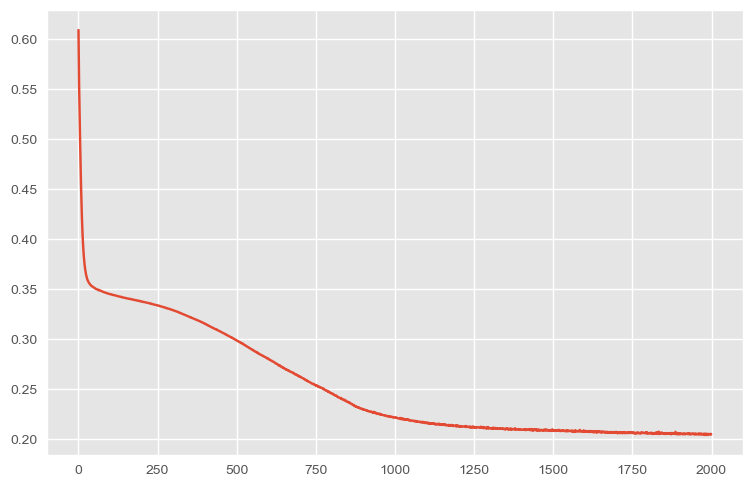

In [369]:
plt.plot(losses)

In [343]:
F.binary_cross_entropy_with_logits(z, y_train_tensor)

tensor(0.6335, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [173]:
def bce_loss_with_logits_naive(inputs, targets):
    sigmas = F.sigmoid(inputs)
    losses = -1 * (targets * sigmas.log() + (1-targets) * (1-sigmas).log())
    return losses.mean()

In [214]:
def bce_loss_with_logits(inputs, targets):
    logses = torch.logsumexp(torch.cat((inputs, torch.zeros_like(inputs)), 1), 1, keepdim=True)
    logsigmas = inputs - logses
    log1msigmas = 0 - logses
    losses = -1 * (targets * logsigmas + (1-targets) * log1msigmas)
    return losses.sum()

In [215]:
bce_loss_with_logits(z, y_train_tensor)

tensor(50.6787)

In [160]:
relu1 = ReLu()

relu1(torch.randn(10) +2)

relu1.forward(torch.randn(10)*10 + 1000)

tensor([1008.5760, 1001.2226, 1024.9048, 1003.4963,  996.3771,  993.7579,
        1005.7107,  991.4001,  998.2122, 1007.8817])

In [150]:
l1 = Linear(2, 5)

In [117]:
# x_input = torch.tensor(np.random.randn(2), dtype=torch.float32)
x_input = torch.randn(100, 2)
# np.zeros(2, dtype='float32').dtype
l1(x_input)

tensor([[ 1.1787e-02,  4.3164e-01,  9.1863e-02,  4.4109e-01, -2.8342e-01],
        [-5.8231e-01, -6.4034e-02,  1.7001e-01,  7.7509e-01,  6.6971e-01],
        [ 4.5906e-01,  2.3334e-01, -9.3530e-02, -4.1695e-01, -6.4264e-01],
        [ 8.0553e-01,  1.0045e+00, -3.2339e-02, -1.0004e-01, -1.5008e+00],
        [-3.5163e-01, -5.2194e-01, -4.3665e-03, -4.4919e-02,  7.0747e-01],
        [ 4.3569e-01,  1.4530e-01, -1.0563e-01, -4.7656e-01, -5.6216e-01],
        [-3.6056e-01, -7.2410e-01, -4.6313e-02, -2.4657e-01,  8.4390e-01],
        [-4.2451e-01, -8.1153e-01, -4.5446e-02, -2.4678e-01,  9.6787e-01],
        [ 1.2925e+00,  1.1882e+00, -1.4569e-01, -6.1007e-01, -2.1424e+00],
        [ 4.8677e-01,  1.0482e+00,  7.8166e-02,  4.0785e-01, -1.1836e+00],
        [-2.0945e-01, -2.8983e-01,  2.0638e-03, -4.3992e-03,  4.0820e-01],
        [-1.4506e+00, -7.9029e-01,  2.8383e-01,  1.2614e+00,  2.0639e+00],
        [-8.5509e-01, -7.3808e-01,  1.0701e-01,  4.5456e-01,  1.3873e+00],
        [ 5.3019e-01,  6.

In [127]:
l1.x

tensor([[-5.0000e+00, -5.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-6.6171e-02,  6.5192e-01],
        [-7.6926e-01,  4.2986e-01],
        [ 4.2741e-01, -8.7486e-02],
        [ 2.0787e-02,  7.1012e-01],
        [ 6.4561e-01,  1.3699e-01],
        [ 7.1511e-01,  1.1208e-01],
        [-7.6938e-01,  1.1980e+00],
        [-9.4913e-01, -2.6970e-01],
        [ 2.3147e-01, -7.7388e-02],
        [ 2.6722e-01, -1.9965e+00],
        [ 4.5633e-01, -8.5017e-01],
        [-5.0744e-01,  2.8171e-01],
        [-5.7541e-01, -2.2526e-01],
        [-5.2060e-01, -7.9763e-01],
        [ 1.3584e+00, -2.5025e-01],
        [ 1.8421e-01,  1.1450e+00],
        [-8.2876e-01, -4.7438e-01],
        [ 1.0965e+00,  1.6466e+00],
        [ 1.8765e-02, -5.7335e-01],
        [-4.5706e-01, -2.6946e-01],
        [-1.2074e-01,  9.4823e-01],
        [ 9.2214e-01,  7.3040e-01],
        [ 1.6530e+00, -1.8687e+00],
        [ 5.4608e-01,  7.4837e-01],
        [-3.9489e-01,  6.4667e-01],
        [ 9.6442e-01,  1.018

In [126]:
x_input[0, :] = -5
x_input

tensor([[-5.0000e+00, -5.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-6.6171e-02,  6.5192e-01],
        [-7.6926e-01,  4.2986e-01],
        [ 4.2741e-01, -8.7486e-02],
        [ 2.0787e-02,  7.1012e-01],
        [ 6.4561e-01,  1.3699e-01],
        [ 7.1511e-01,  1.1208e-01],
        [-7.6938e-01,  1.1980e+00],
        [-9.4913e-01, -2.6970e-01],
        [ 2.3147e-01, -7.7388e-02],
        [ 2.6722e-01, -1.9965e+00],
        [ 4.5633e-01, -8.5017e-01],
        [-5.0744e-01,  2.8171e-01],
        [-5.7541e-01, -2.2526e-01],
        [-5.2060e-01, -7.9763e-01],
        [ 1.3584e+00, -2.5025e-01],
        [ 1.8421e-01,  1.1450e+00],
        [-8.2876e-01, -4.7438e-01],
        [ 1.0965e+00,  1.6466e+00],
        [ 1.8765e-02, -5.7335e-01],
        [-4.5706e-01, -2.6946e-01],
        [-1.2074e-01,  9.4823e-01],
        [ 9.2214e-01,  7.3040e-01],
        [ 1.6530e+00, -1.8687e+00],
        [ 5.4608e-01,  7.4837e-01],
        [-3.9489e-01,  6.4667e-01],
        [ 9.6442e-01,  1.018

In [124]:
l1.parameters()

[tensor([[-0.6930, -1.1723, -0.0404, -0.2410,  1.4843],
         [ 0.6338,  0.2389, -0.1476, -0.6640, -0.8351]]),
 tensor([0., 0., 0., 0., 0.])]

In [114]:
# help(np.random.randn)

In [115]:
rng = np.random.default_rng(12345)

In [116]:
rng.standard_normal((10,2))

array([[-1.42382504,  1.26372846],
       [-0.87066174, -0.25917323],
       [-0.07534331, -0.74088465],
       [-1.3677927 ,  0.6488928 ],
       [ 0.36105811, -1.95286306],
       [ 2.34740965,  0.96849691],
       [-0.75938718,  0.90219827],
       [-0.46695317, -0.06068952],
       [ 0.78884434, -1.25666813],
       [ 0.57585751,  1.39897899]])

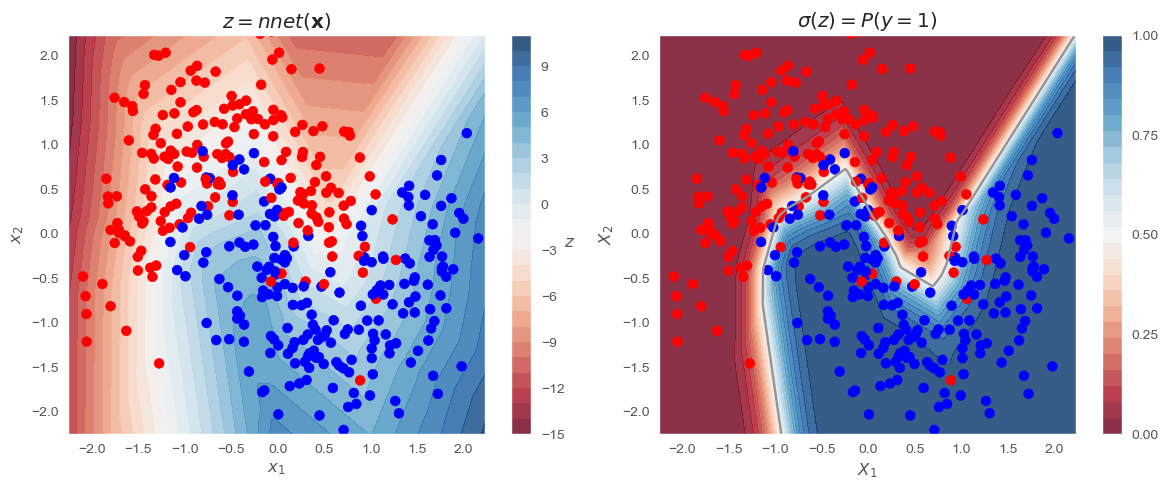

In [465]:
fig=figure7(x_train_tensor, y_train_tensor, nnet,'cpu')

In [464]:
def figure7(X, y, model, device, cm=None, cm_bright=None):
    if cm is None:
        cm = plt.cm.RdBu
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig = plt.figure(figsize=(12, 5))

    h = .02  # step size in the mesh

    # x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    # y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    
    x_min, x_max = -2.25, 2.25
    y_min, y_max = -2.25, 2.25
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    logits = logits.detach().cpu().numpy().reshape(xx.shape)

    yhat = sigmoid(logits)

    # 1st plot
    ax = plt.subplot(1, 2, 1)

    contour = ax.contourf(xx, yy, logits, 25, cmap=cm, alpha=.8)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title(r'$z = nnet(\mathbf{x})$')
    ax.grid(False)
    ax_c = plt.colorbar(contour)
    ax_c.set_label("$z$", rotation=0)

    # 2nd plot
#     ax = fig.add_subplot(1, 3, 2, projection='3d')

#     surf = ax.plot_surface(xx, yy, yhat, rstride=1, cstride=1, alpha=.5, cmap=cm, linewidth=0, antialiased=True, vmin=0, vmax=1)
#     # Plot the training points
#     ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
#     # Plot the testing points
#     #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xlabel(r'$X_1$')
#     ax.set_ylabel(r'$X_2$')
#     ax.set_title(r'$\sigma(z) = P(y=1)$')

#     ax_c = plt.colorbar(surf)
#     ax_c.set_ticks([0, .25, .5, .75, 1])
#     ax.view_init(30, 220)

    # 3rd plot
    ax = plt.subplot(1, 2, 2)

    ax.contour(xx, yy, yhat, levels=[.5], cmap="Greys", vmin=0, vmax=1)
    contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.8, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')
    ax.grid(False)

    ax_c = plt.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])

    plt.tight_layout()
    
    return fig

In [452]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Regression dataset

In [477]:
def true_f(x):
    return -5 * np.tanh(0.5 * x) * (1. - np.tanh(0.5 * x)**2)
rng = np.random.default_rng(100)
x_input = np.linspace(-8, 8, 50)
y_output = true_f(x_input) + np.sqrt(0.05) * rng.standard_normal(len(x_input))

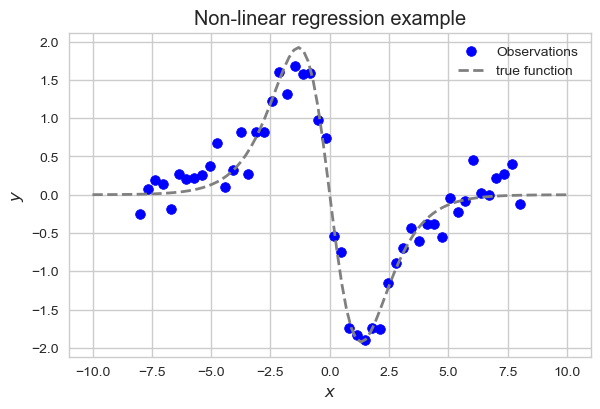

In [537]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x_input, y_output, color='blue', label="Observations")
xs = np.linspace(-10,10, 100)
ys = true_f(xs)
ax.plot(xs, ys, c="gray", linestyle='dashed',
     linewidth=2, label="true function")
ax.set(xlabel=r'$x$', ylabel=r'$y$',
       title='Non-linear regression example')
ax.legend()
plt.show()

## Non-linear classification data (two balls)

In [604]:
n_ = 30
D1 = rng.standard_normal((n_, 2))
D2_1 = np.array([5, 5]) + rng.standard_normal((n_, 2))
D2_2 = np.array([-5, -5]) + rng.standard_normal((n_, 2))
D2 = np.vstack((D2_1, D2_2))
Xs_train_class = np.vstack((D1, D2))
ys_train_class = np.repeat([0, 1], [n_, 2* n_])

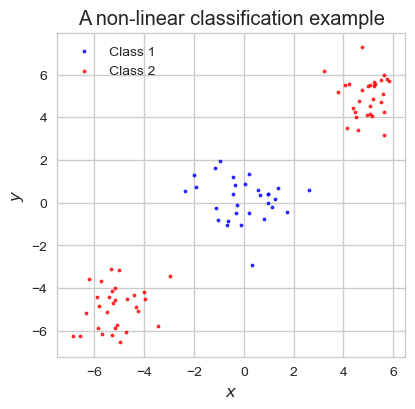

In [608]:
fig, ax = plt.subplots(figsize = (4,4))
ax.scatter(D1[:, 0],D1[:, 1], s = 5, alpha=0.8, color='blue', label="Class 1")
ax.scatter(D2[:, 0],D2[:, 1], s = 5, alpha=0.8, color='red', label="Class 2")
ax.set(xlabel=r'$x$', ylabel=r'$y$',
       title='A non-linear classification example')
ax.legend()
plt.show()

## Non-linear classification data (smile dataset)

In [509]:
np.hstack

array([[0.50157401, 0.4663081 , 0.07369337, 0.44209638, 0.22351108,
        0.30297573, 0.39434801, 0.70663065, 0.78636314, 0.3568361 ]])

In [561]:
def generate_real_data(n):
    x1 = rng.random((n, 1)) - 0.5
    x2 = (x1 * x1)*3 + rng.standard_normal((n, 1)) * 0.1
    return np.hstack((x1, x2))

def generate_fake_data(n):
    theta = 2 * np.pi * rng.random((n, 1))
    r = rng.random((n, 1)) / 3
    x1 = r * np.cos(theta)
    x2 = r * np.sin(theta) + 0.5
    return np.hstack((x1, x2))
# Creating our data
train_size = 1000
real = generate_real_data(train_size)
fake = generate_fake_data(train_size)

Xs_train_smile = np.hstack((real, fake))
ys_train_smile = np.hstack((np.ones(real.shape[0]), np.zeros(fake.shape[0])))
test_size = 1000
real_test = generate_real_data(test_size)
fake_test = generate_fake_data(test_size)
Xs_test_smile = np.hstack((real_test, fake_test))
ys_test_smile = np.hstack((np.ones(real_test.shape[0]), np.zeros(fake_test.shape[0])))

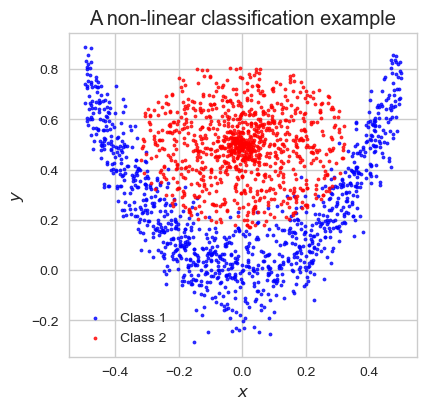

In [563]:
fig, ax = plt.subplots(figsize = (4,4))
ax.scatter(real[:, 0],real[:, 1], s = 5, alpha=0.8, color='blue', label="Class 1")
ax.scatter(fake[:, 0],fake[:, 1], s = 5, alpha=0.8, color='red', label="Class 2")
ax.set(xlabel=r'$x$', ylabel=r'$y$',
       title='A non-linear classification example')
ax.legend()
plt.show()